<a href="https://colab.research.google.com/github/abibowering/ASGM-Peru/blob/main/Graphs_Correct_for_Combined_Interventions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This version of the code creates all graphs in v1 of the paper
## abi, aug 20, 2025


In [1]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
#Import required packages
import csv
import numpy as np
import pandas as pd
#https://networkx.org/documentation/stable/tutorial.html
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz as pgv

## defining functions

In [3]:
#funciton to get components
#returns a list of components
def get_hte_components(infilename):
    with open (infilename, mode='r', encoding='utf-8-sig') as infile:
        reader = csv.reader(infile)
        #create a dictionary with descriptions of the components
        compdict={rows[0]:rows[1] for rows in reader}

    #create a list from components
    Componentlist = np.array(list(compdict.items()))
    return Componentlist, compdict

In [4]:
#function that creates graph from list of interactions and components
def create_hte_graph(components, compdict, infilename):

    #Read in the base case interactions file into a data frame
    df = pd.read_csv(infilename, sep=',', header=None)
    interactions=pd.DataFrame(df).to_numpy()

    #convert edges to tuple
    edgeint=interactions[:,0:4]
    edge3tup=tuple([tuple(row) for row in edgeint[:,0:3]])

    #make dictionaries for interactions descriptions
    interactions3dict={(edgeint[k,0],edgeint[k,1],edgeint[k,2]):edgeint[k,3] for k in range(len(edgeint))}
    interactionsdict={(edgeint[k,0],edgeint[k,1]):edgeint[k,3] for k in range(len(edgeint))}

    #Create a matrix from a Multi, directed graph for the base case, put in the information
    B=nx.MultiDiGraph()

    #Add components to the graph as nodes
    B.add_nodes_from(compdict.keys())
    for key, n in B.nodes.items():
        n["description"]=compdict[key]

    #add interactions to the graph as edges, with key as I, K
    B.add_edges_from(edge3tup)
    for key, n in B.edges.items():
        n["description"]=interactions3dict[key]

    return(B)

In [5]:
#this function returns a subgraph with source and target
def sourcetargetgraph(graph, source, target):
    num=1
    newgraph=nx.DiGraph()
    paths=nx.all_simple_paths(graph,source=source,target=target)
    for pathz in map(nx.utils.pairwise, paths):
        a=tuple(pathz)
        #print(a)
        #add edges to the new plot
        newgraph.add_edges_from(a)
        num=num+1
    return newgraph, num


In [6]:
#plot function
def plotgraph_dot(graph, outfilename):
    Z = nx.nx_agraph.to_agraph(graph)
    #here is where we add the descriptions
    ndlist=graph.nodes()
    for node in ndlist:
        label = compdict[node]
        Z.add_node(node, label=label)
    #elist=xvis.edges()

    Z.layout(prog='dot')
    Z.draw(outfilename, format='eps')
#W.write("next.dot")

In [7]:
#node-focused analysis
def updown_hte(ingraph, targetnode):


    upstream = [n for n in nx.traversal.bfs_tree(ingraph, targetnode, reverse=True) if n != targetnode]
    downstream = [n for n in nx.traversal.bfs_tree(ingraph, targetnode) if n != targetnode]

    lenu=len(upstream)
    lend=len(downstream)

    if len(upstream) > 0 and len(downstream) > 0:
        ratio=(len(upstream)/len(downstream))
    else:
        #NOTE THIS IS SET AT ZERO FOR EASE OF PLOTTING LATER, SHOULD REALLY BE NAN
        ratio=0
    return upstream, downstream, lenu, lend, ratio

In [8]:
#How connected is each node to each other? Now normalized to top number of connections for each matrix.

def get_hte_connect_matrix(matrixin):
    IC=matrixin.copy()
    connectedmatrix=pd.DataFrame(data=None, index=IC.nodes(), columns=IC.nodes())
    for source in IC.nodes():
        for target in IC.nodes():
            connectedmatrix.loc[source,target]=len(list(nx.all_simple_paths(IC,source=source,target=target)))
    #normalize relative to the most connected node
    a=connectedmatrix.loc[connectedmatrix.stack().idxmax()]
    connectednorm=connectedmatrix.div(a)
  #debug  print(connectedmatrix.loc[connectedmatrix.stack().idxmax()])
    return connectednorm


## Analysis -- read in data

### input files are components and interactions matrices
### outputs are matrices B, OM, T, M, L
### hte is a dataframe with all the data

In [9]:
!git clone https://github.com/abibowering/ASGM-Peru.git

fatal: destination path 'ASGM-Peru' already exists and is not an empty directory.


In [10]:
##Read in the components and create base case and three interaction case matrices

#read in components list
clist,compdict=get_hte_components("/content/ASGM-Peru/components_all.csv")

#base case matrix
B=create_hte_graph(clist,compdict, "/content/ASGM-Peru/interactions_base.csv")
B.graph['title']='Base'

#tech case matrix
T=create_hte_graph(clist,compdict, "/content/ASGM-Peru/interactions_t.csv")
T.graph['title']='Tech'

#mkt case matrix
M=create_hte_graph(clist,compdict,"/content/ASGM-Peru/interactions_mt.csv")
M.graph['title']='Mkt'

#legal case matrix
L=create_hte_graph(clist,compdict,"/content/ASGM-Peru/interactions_lmt.csv")
L.graph['title']='Lgl'

In [11]:
#Make a duplicate of B and remove nodes to create Operation Mercury case
OM=B.copy()
OM.remove_node('E3')

#OM.remove_edge('E3','T4')
OM.graph['title']=('OpHg')

In [12]:
#create centrality dataframe for all cases

graphs=[B,T,M,L]
clist=[]
columns=[]
for items in graphs:
    central=nx.degree_centrality(items)
    centraltitle=items.graph['title']+'_degree'
    bcentral=nx.betweenness_centrality(items)
    bcentraltitle=items.graph['title']+'_between'
    columns.append(centraltitle)
    clist.append(list(central.values()))
    columns.append(bcentraltitle)
    clist.append(list(bcentral.values()))

c2=pd.DataFrame(clist, index=columns, columns=list(central))

c3=c2.T

graphs=[OM]
clist=[]
columns=[]
for items in graphs:
    central=nx.degree_centrality(items)
    centraltitle=items.graph['title']+'_degree'
    bcentral=nx.betweenness_centrality(items)
    bcentraltitle=items.graph['title']+'_between'
    columns.append(centraltitle)
    clist.append(list(central.values()))
    columns.append(bcentraltitle)
    clist.append(list(bcentral.values()))

c2=pd.DataFrame(clist, index=columns, columns=list(central))

c_om=c2.T

#show the centrality dataframe, add it to c3
c_om
c4=c3.join(c_om)
#c4

In [13]:
#upstream, downstream ratios for each node

graphs=[B,T,M,L]

clist=[]
columns=[]

for items in graphs:
    ratio=[]
    lenu=[]
    lend=[]
    ndlist=items.nodes()
    for node in ndlist:
        udr=updown_hte(items,node)
        lenu.append(udr[2])
        lend.append(udr[3])
        ratio.append(udr[4])
    utitle=items.graph['title']+'_upstream'
    dtitle=items.graph['title']+'_downstream'
    rtitle=items.graph['title']+'_ratio'
    columns.append(utitle)
    columns.append(dtitle)
    columns.append(rtitle)

    clist.append(list(lenu))
    clist.append(list(lend))
    clist.append(list(ratio))

updown=pd.DataFrame(clist, index=columns, columns=ndlist)
updown=updown.T
updown

graphs=[OM]

clist=[]
columns=[]

for items in graphs:
    ratio=[]
    lenu=[]
    lend=[]
    ndlist=items.nodes()
    for node in ndlist:
        udr=updown_hte(items,node)
        lenu.append(udr[2])
        lend.append(udr[3])
        ratio.append(udr[4])
    utitle=items.graph['title']+'_upstream'
    dtitle=items.graph['title']+'_downstream'
    rtitle=items.graph['title']+'_ratio'
    columns.append(utitle)
    columns.append(dtitle)
    columns.append(rtitle)

    clist.append(list(lenu))
    clist.append(list(lend))
    clist.append(list(ratio))

updown2=pd.DataFrame(clist, index=columns, columns=ndlist)
updown2=updown2.T
updown3=updown.join(updown2)
#updown3

In [14]:
#closeness centrality
graphs=[B,T,M,L]
clist=[]
columns=[]

for items in graphs:
    central=nx.closeness_centrality(items)
    centraltitle=items.graph['title']+'_closeness'
    columns.append(centraltitle)
    clist.append(list(central.values()))

c2=pd.DataFrame(clist, index=columns, columns=list(central))

close=c2.T
graphs=[OM]
clist=[]
columns=[]

for items in graphs:
    central=nx.closeness_centrality(items)
    centraltitle=items.graph['title']+'_closeness'
    columns.append(centraltitle)
    clist.append(list(central.values()))

c2=pd.DataFrame(clist, index=columns, columns=list(central))

closeom=c2.T

close2=close.join(closeom)
#close2


In [15]:
#make a big dataframe

hte=close2.join(updown3)
hte=hte.join(c4)
#hte

## now the graphs

In [41]:
#First, pull the centrality quantitative measures


In [42]:
basecentral=hte.loc[['H1','H2','H3','H4','H5','T5','T11','E5','E6'],['Base_degree','Base_between','Base_closeness','Base_upstream','Base_downstream']]
omcentral=hte.loc[['H1','H2','H3','H4','H5','T5','T11','E5','E6'],['OpHg_degree','OpHg_between','OpHg_closeness','OpHg_upstream','OpHg_downstream']]
techcentral=hte.loc[['H1','H2','H3','H4','H5','T5','T11','E5','E6'],['Tech_degree','Tech_between','Tech_closeness','Tech_upstream','Tech_downstream']]
mktcentral=hte.loc[['H1','H2','H3','H4','H5','T5','T11','E5','E6'],['Mkt_degree','Mkt_between','Mkt_closeness','Mkt_upstream','Mkt_downstream']]
lglcentral=hte.loc[['H1','H2','H3','H4','H5','T5','T11','E5','E6'],['Lgl_degree','Lgl_between','Lgl_closeness','Lgl_upstream','Lgl_downstream']]
lglcentral


,Lgl_degree,Lgl_between,Lgl_closeness,Lgl_upstream,Lgl_downstream
H1,0.413793,0.205145,0.282876,22.0,27.0
H2,0.275862,0.075130,0.282876,22.0,27.0
H3,0.206897,0.032562,0.333793,22.0,27.0
H4,0.172414,0.023399,0.309068,22.0,27.0
H5,0.172414,0.159820,0.309068,22.0,27.0
T5,0.275862,0.144353,0.219601,22.0,27.0
T11,0.241379,0.029557,0.321668,25.0,1.0
E5,0.379310,0.203422,0.388132,22.0,27.0
E6,0.068966,0.028325,0.212109,23.0,1.0


In [43]:


#number of simple paths
#print('# of simple paths -base', base)
#print('# of simple paths -om', oml, '%', (oml-base)/base*100)
#print('# of simple paths -tech',tech,'%',(tech-base)/base*100 )
#print('# of simple paths -mkt', )
#print('# of simple paths -lgl', )

sourcetargetlist=(('H1','H8'),('H2','H8'),('T5','H3'),('T5','H4'),('T5','H5'),('H1','H3'),('H1','H4'),('H1','H5'),('H2','H3'),('H2','H4'),('H2','H5'),('T5','E5'),('T5','E6'),('E5','H3'),('E5','H4'),('E5','H5'))


with open('data_paths.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    toprow=('Source','Target','Base-paths','OM-paths','OM-%','Tech-paths','Tech-%','Mkt-paths','Mkt-%','Lgl-paths','Lgl-%')
    spamwriter.writerow(toprow)

with open('data_paths_tableformat.csv', 'w', newline='') as csvfile:
    tablewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    toprow=('Source','Target','Base-paths','OM-paths (%)','Tech-paths (%)','Mkt-paths (%)','Lgl-paths (%)')
    tablewriter.writerow(toprow)
    for x in sourcetargetlist:
        source=x[0]
        target=x[1]
        base=len(list(nx.all_simple_paths(B,source=source,target=target)))
        oml=len(list(nx.all_simple_paths(OM,source=source,target=target)))
        tech=len(list(nx.all_simple_paths(T,source=source,target=target)))
        mkt=len(list(nx.all_simple_paths(M,source=source,target=target)))
        lgl=len(list(nx.all_simple_paths(L,source=source,target=target)))

        row=(source,target,base,oml,(oml-base)/base*100,tech,(tech-base)/base*100,mkt,(mkt-base)/base*100,lgl,(lgl-base)/base*100)
      #  spamwriter.writerow(row)

        #Now make it in the format of the table in the paper
        omlstring=str(oml)+'('+str(round((oml-base)/base*100))+'%)'
        techstring=str(tech)+'('+str(round((tech-base)/base*100))+'%)'
        mktstring=str(mkt)+'('+str(round((mkt-tech)/tech*100))+'%)'
        lglstring=str(lgl)+'('+str(round((lgl-mkt)/mkt*100))+'%)'

        tablerow=(source,target,base,omlstring,techstring,mktstring,lglstring)
        tablewriter.writerow(tablerow)

In [44]:
rowstring=str(lgl)+'('+str((lgl-base)/base*100)+'%)'
print(rowstring)

19(533.3333333333333%)


In [45]:
source="H1"
target="H8"

#number of simple paths
print('# of simple paths -base', len(list(nx.all_simple_paths(B,source=source,target=target))))

#shortest path description
paths=nx.all_shortest_paths(B,source=source,target=target)

for pathz in map(nx.utils.pairwise, paths):
        #print(tuple(pathz))
        a=tuple(pathz)
        for k in a:
            print(k)
            print(B[k[0]][k[1]])



# of simple paths -base 222
('H1', 'T8')
{'K3': {'description': 'LM miners use field-based separation technology'}}
('T8', 'T11')
{'K1': {'description': 'Field-based separation technology separates out gold'}}
('T11', 'H8')
{'I3': {'description': 'Gold bought by gold buyers'}}


In [46]:
cc=hte.loc[['H1','H2','H3','H4','H5','T5','T11','E5','E6'],['Base_degree','Base_between','Base_closeness','Base_upstream','Base_downstream']]
cc

,Base_degree,Base_between,Base_closeness,Base_upstream,Base_downstream
H1,0.310345,0.137113,0.257744,21.0,23.0
H2,0.275862,0.074200,0.257744,21.0,23.0
H3,0.206897,0.032650,0.323551,21.0,23.0
H4,0.172414,0.022475,0.298174,21.0,23.0
H5,0.172414,0.142998,0.298174,21.0,23.0
T5,0.241379,0.091491,0.190086,21.0,23.0
T11,0.172414,0.027094,0.268256,23.0,1.0
E5,0.379310,0.193842,0.370900,21.0,23.0
E6,0.068966,0.027094,0.198686,22.0,1.0


In [47]:
plotgraph_dot(L,'Legal_new.eps')


<Axes: >

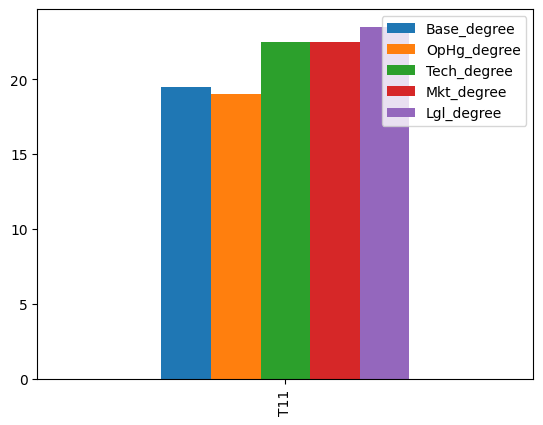

In [48]:
target='T11'

ranks=hte.rank(axis=0,method='average')

degree=hte.loc[[target],['Base_degree','OpHg_degree','Tech_degree','Mkt_degree','Lgl_degree']]
between=hte.loc[[target],['Base_between','OpHg_between','Tech_between','Mkt_between','Lgl_between']]
nodecent=degree.join(between)
#degree.plot.bar()


cc=ranks.loc[[target],['Base_degree','OpHg_degree','Tech_degree','Mkt_degree','Lgl_degree']]
cc.plot.bar()

Text(0.5, 1.0, 'Degree Centrality')

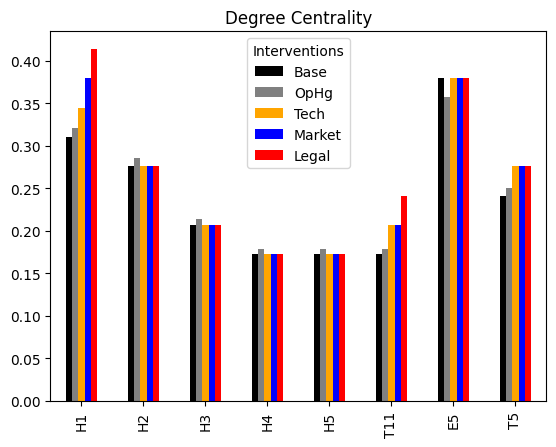

In [49]:
cc=hte.loc[['H1','H2','H3','H4','H5','T11','E5','T5'],['Base_degree','OpHg_degree','Tech_degree','Mkt_degree','Lgl_degree']]
color=['k','gray','orange','b','r']
cc.plot.bar(color=color)
plt.legend(title='Interventions', labels=('Base','OpHg','Tech','Market','Legal'))
plt.title('Degree Centrality')

Text(0.5, 1.0, 'Betweenness Centrality')

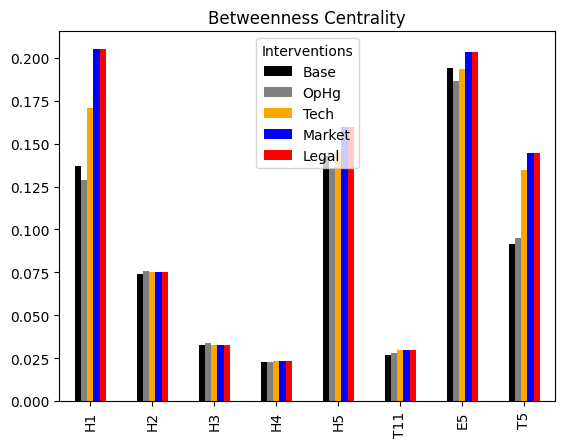

In [50]:
cc=hte.loc[['H1','H2','H3','H4','H5','T11','E5','T5'],['Base_between','OpHg_between','Tech_between','Mkt_between','Lgl_between']]
color=['k','gray','orange','b','r']
cc.plot.bar(color=color)
plt.legend(title='Interventions', labels=('Base','OpHg','Tech','Market','Legal'), loc='upper center')
plt.title('Betweenness Centrality')

Text(0.5, 1.0, 'Centrality Comparison')

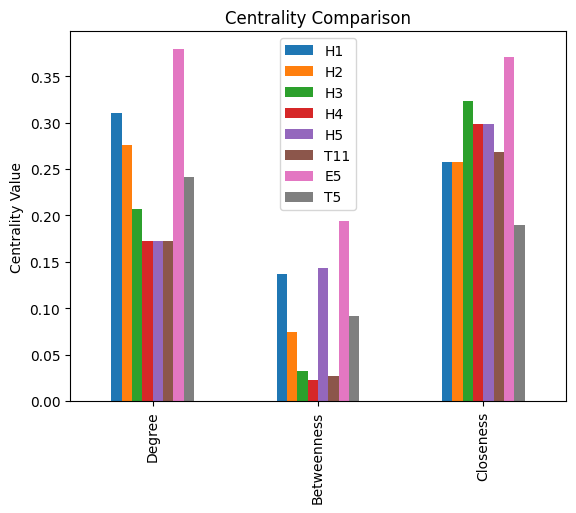

In [51]:
cc = hte.loc[['H1','H2','H3','H4','H5','T11','E5','T5'],
             ['Base_degree','Base_between','Base_closeness']]

cct = cc.T
ax = cct.plot.bar()

# Set proper tick labels
ax.set_xticks(range(len(cct.index)))
ax.set_xticklabels(['Degree','Betweenness','Closeness'])

# Optional: axis label and title
ax.set_ylabel("Centrality Value")
ax.set_title("Centrality Comparison")


In [52]:
# cd=cc.pivot(cc,)

In [53]:
cct=cc.T

In [54]:
cc.T

,H1,H2,H3,H4,H5,T11,E5,T5
Base_degree,0.310345,0.275862,0.206897,0.172414,0.172414,0.172414,0.379310,0.241379
Base_between,0.137113,0.074200,0.032650,0.022475,0.142998,0.027094,0.193842,0.091491
Base_closeness,0.257744,0.257744,0.323551,0.298174,0.298174,0.268256,0.370900,0.190086


In [55]:
source="H2"
target="H8"
#which matrix
M=OM

#number of simple paths
print('# of simple paths', len(list(nx.all_simple_paths(M,source=source,target=target))))

#shortest path description
paths=nx.all_shortest_paths(M,source=source,target=target)

for pathz in map(nx.utils.pairwise, paths):
        #print(tuple(pathz))
        a=tuple(pathz)
        for k in a:
            print(k)
            print(B[k[0]][k[1]])

upstream = [n for n in nx.traversal.bfs_tree(M, source, reverse=True) if n != source]
print(len(upstream))
print(upstream)

# of simple paths 218
('H2', 'T3')
{'K1': {'description': 'HM miners use high mechanized mining equipment'}}
('T3', 'T6')
{'K1': {'description': 'High mechanized mining equipment provides inputs for large-scale gold processing equipment'}}
('T6', 'T11')
{'K1': {'description': 'Large-scale processing equipment produces gold'}}
('T11', 'H8')
{'I3': {'description': 'Gold bought by gold buyers'}}
20
['H5', 'T1', 'T5', 'E1', 'H1', 'E5', 'H6', 'H3', 'H4', 'T6', 'E2', 'E4', 'E7', 'H7', 'T3', 'T2', 'T8', 'T9', 'T7', 'T4']


Text(0.5, 1.0, 'Change in Betweenness')

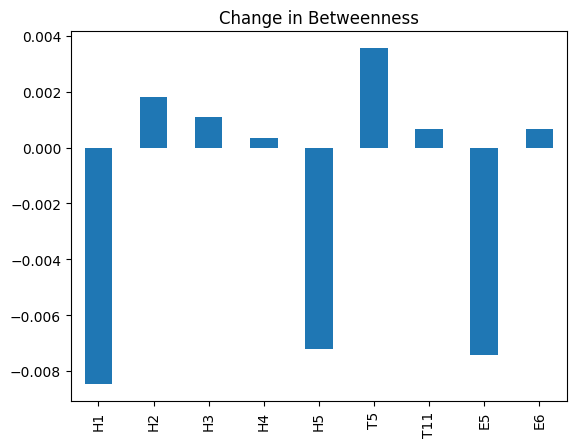

In [56]:
cc = hte["OpHg_between"] - hte["Base_between"]
dd = cc[['H1','H2','H3','H4','H5','T5','T11','E5','E6']]

ax = dd.plot.bar()
ax.set_title("Change in Betweenness")


Text(0.5, 1.0, 'Change in Degree')

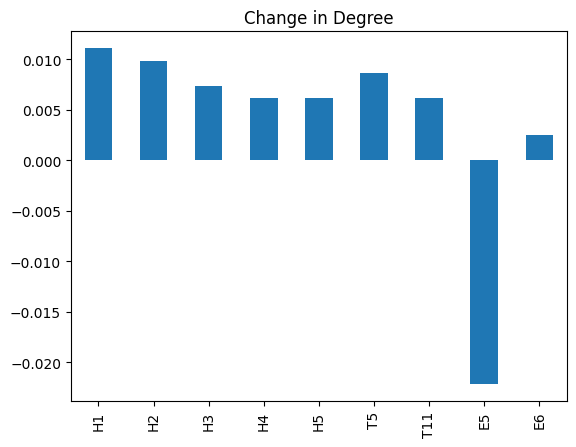

In [57]:
cc=hte["OpHg_degree"]-hte["Base_degree"]
dd=cc[['H1','H2','H3','H4','H5','T5','T11','E5','E6']]
dd.plot.bar()

plt.title('Change in Degree')

Text(0.5, 1.0, 'Change in Closeness')

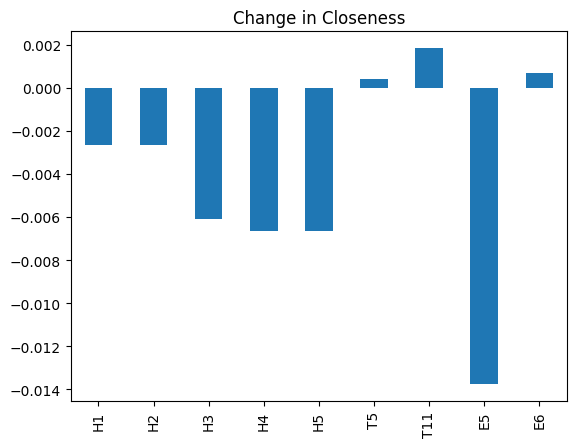

In [58]:
cc=hte["OpHg_closeness"]-hte["Base_closeness"]
dd=cc[['H1','H2','H3','H4','H5','T5','T11','E5','E6']]
dd.plot.bar()

plt.title('Change in Closeness')

In [59]:
deg=hte["OpHg_degree"]-hte["Base_degree"]
clo=hte["OpHg_closeness"]-hte["Base_closeness"]
bet=hte["OpHg_between"]-hte["Base_between"]
nodelist=['H1','H2','H3','H4','H5','T5','T11','E5','E6']
#make a dataframe
co=pd.DataFrame(clo[nodelist],bet[nodelist])
c2=pd.DataFrame(clist, index=columns, columns=list(central))
#fig, (ax1, ax2) = plt.subplots(1, 2)

In [60]:
co=(deg,bet,clo)
centralchange=pd.DataFrame(co, index=('degree','betweenness','closeness'))
centralchange=centralchange.T
centralchange

,degree,betweenness,closeness
H1,0.011084,-0.008472,-0.002642
H2,0.009852,0.001815,-0.002642
H3,0.007389,0.001096,-0.006091
H4,0.006158,0.000342,-0.006629
H5,0.006158,-0.007221,-0.006629
H6,0.007389,0.003376,0.001333
H7,0.006158,0.001291,-0.004232
H8,0.002463,0.000000,0.000679
H9,0.001232,0.000000,0.000666
H10,0.000000,0.000000,0.000000


Text(0.5, 1.0, 'Change in Centrality for Operation Mercury')

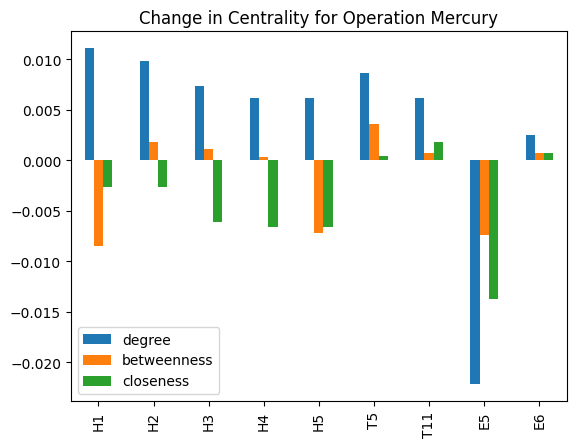

In [61]:
nodelist=['H1','H2','H3','H4','H5','T5','T11','E5','E6']
plotter=centralchange.loc[nodelist]
a=plotter.plot.bar()
plt.title('Change in Centrality for Operation Mercury')

/tmp/ipython-input-1479184162.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set2', 8)


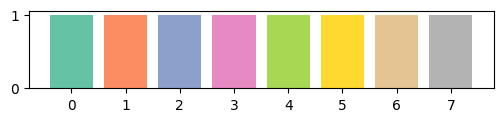

In [62]:
import matplotlib.cm as cm

cmap = cm.get_cmap('Set2', 8)
plt.figure(figsize=(6,1))
for i in range(cmap.N):
    plt.bar(i, 1, color=cmap(i))
plt.show()


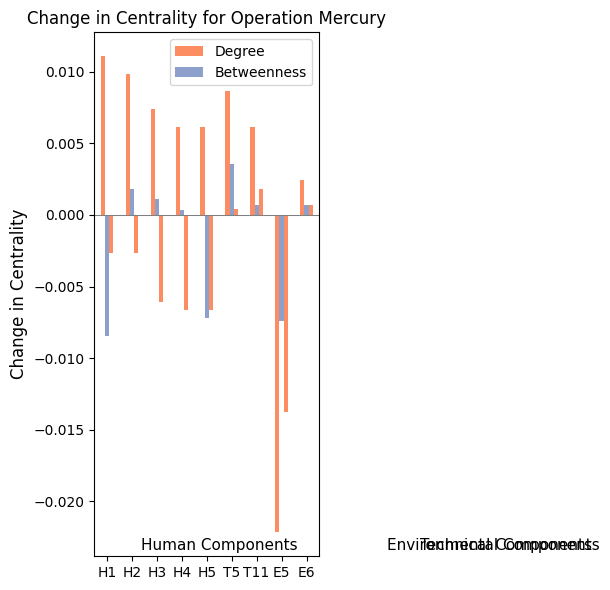

In [63]:
import matplotlib.pyplot as plt

# Bar plot
a = plotter.plot.bar(color=[cmap(1), cmap(2)], figsize=(12,6))
plt.xticks(rotation=0)

# Vertical separators
h_end = 9   # index of H10
t_end = 22  # index of T13

a.axvline(h_end + 0.5, color="black", linewidth=0.75, linestyle="--")  # Between H10 and T1
a.axvline(t_end + 0.5, color="black", linewidth=0.75, linestyle="--")  # Between T13 and E1

# Axis labels
a.set_xlabel("")
a.set_ylabel("Change in Centrality", fontsize=12)
a.axhline(0, color="grey", linewidth=0.75)

# Bracket drawing
def add_bracket(ax, x0, x1, label, y=-0.1):
    transform = ax.get_xaxis_transform()
    ax.text((x0 + x1) / 2, y, label, ha="center", va="top",
            transform=transform, fontsize=11, color="black")

# Add brackets ABOVE the x-axis
add_bracket(a, -0.5, h_end + 0.5, "Human Components", y=0.035)
add_bracket(a, h_end + 0.5, t_end + 0.5, "Technical Components", y=0.035)
add_bracket(a, t_end + 0.5, len(plotter.index) - 0.5, "Environmental Components", y=0.035)

# Legend
handles, _ = a.get_legend_handles_labels()
a.legend(handles, ["Degree", "Betweenness"])

plt.title("Change in Centrality for Operation Mercury")
plt.tight_layout()
plt.show()


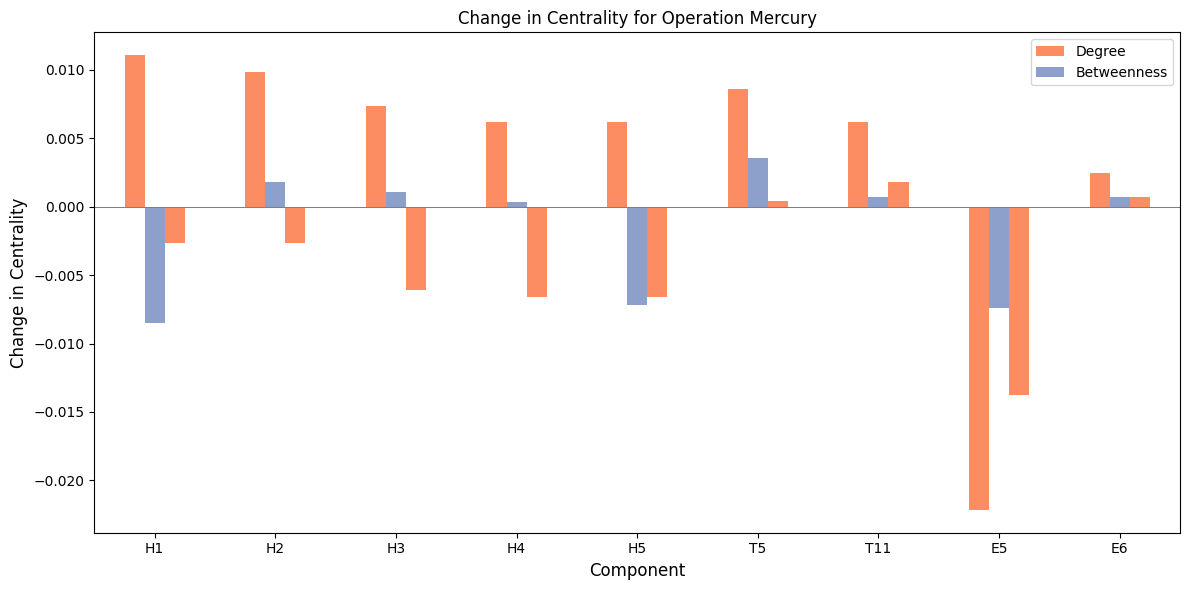

In [64]:
# Plot
a = plotter.plot.bar(color=[cmap(1), cmap(2)], figsize=(12,6))
plt.xticks(rotation=0)

# Vertical separators
a.axvline(h_end + 0.5, color="grey", linewidth=0.75)
a.axvline(t_end + 0.5, color="grey", linewidth=0.75)

# Get legend handles (colors) and override the text
handles, _ = a.get_legend_handles_labels()
a.legend(handles, ["Degree", "Betweenness"])

# Axis labels
a.set_xlabel("Component", fontsize=12)
a.set_ylabel("Change in Centrality", fontsize=12)
a.axhline(0, color="grey", linewidth=0.75)
plt.title("Change in Centrality for Operation Mercury")
plt.tight_layout()
plt.show()


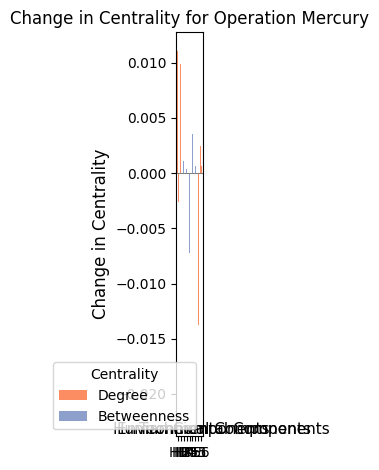

In [65]:
import matplotlib.pyplot as plt

a = plotter.plot.bar(color=[cmap(1), cmap(2)])
plt.xticks(rotation=0)

# Vertical separators
a.axvline(h_end + 0.5, color="black", linewidth=0.75, linestyle="--")
a.axvline(t_end + 0.5, color="black", linewidth=0.75, linestyle="--")

# Axis labels
a.set_xlabel("")
a.set_ylabel("Change in Centrality", fontsize=12)
a.axhline(0, color="grey", linewidth=0.75)

# Bracket drawing in axes coordinates (label only, no ticks)
def add_bracket(ax, x0, x1, label, y=-0.1):
    """
    x0, x1 are positions in data coordinates.
    y is relative to axis coords (negative = below x-axis).
    Only the label is drawn, no side ticks.
    """
    transform = ax.get_xaxis_transform()  # x in data, y in axis fraction

    # Label in the middle
    ax.text((x0 + x1) / 2, y, label, ha="center", va="top",
            transform=transform, fontsize=11, color="black")

# Add brackets ABOVE the ticks
add_bracket(a, -0.5, h_end+0.5, "Human Components", y=0.035)
add_bracket(a, h_end+0.5, t_end+0.5, "Technical Components", y=0.035)
add_bracket(a, t_end+0.5, len(plotter.index)-0.5, "Environmental Components", y=0.035)

# Legend
handles, _ = a.get_legend_handles_labels()
a.legend(handles, ["Degree", "Betweenness"], title="Centrality")

plt.title("Change in Centrality for Operation Mercury")
plt.tight_layout()
plt.show()



Text(0.5, 1.0, 'Change in Centrality for Operation Mercury')

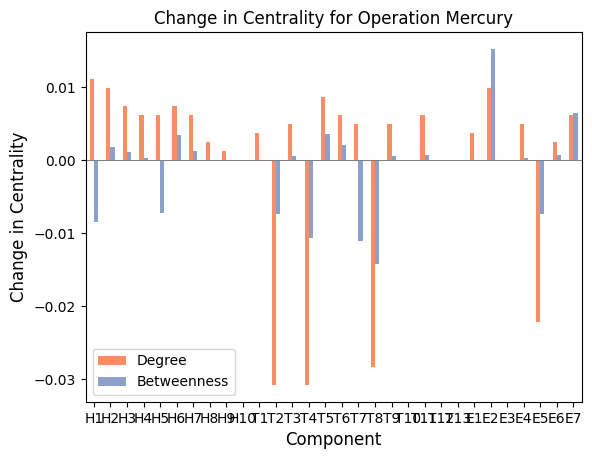

In [66]:
dbo=(deg,bet)
centralchangeo=pd.DataFrame(dbo, index=('degree','betweenness'))
centralchangeo=centralchangeo.T
centralchangeo
plotter=centralchangeo


a=plotter.plot.bar(color=[cmap(1), cmap(2)])
plt.xticks(rotation=0)   # applies to current Axes
a.legend(labels=["Degree", "Betweenness"])
a.set_xlabel("Component", fontsize=12)
a.set_ylabel("Change in Centrality", fontsize=12)
a.axhline(0, color="grey", linewidth=0.75)

plt.title('Change in Centrality for Operation Mercury')


Text(0.5, 1.0, 'Change in Centrality for Operation Mercury')

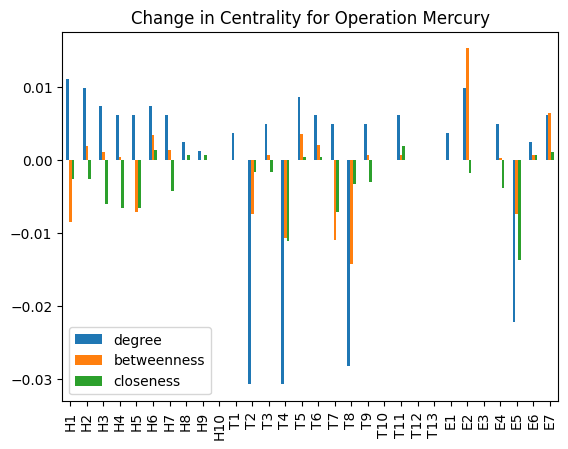

In [67]:
nodelist=['H1','H2','H3','H4','H5','T5','T11','E5','E6']
plotter=centralchange
a=plotter.plot.bar()
plt.title('Change in Centrality for Operation Mercury')

Text(0.5, 1.0, 'Change in Centrality for Operation Mercury')

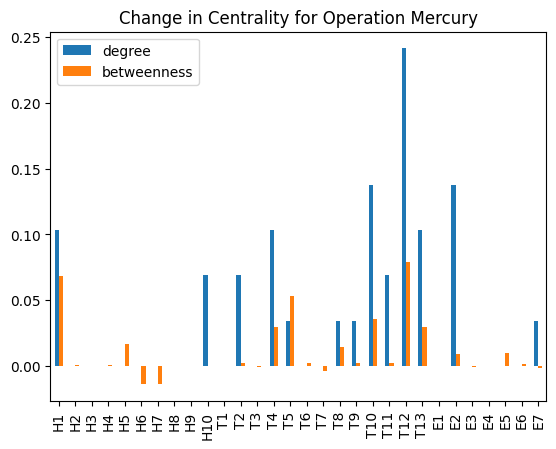

In [68]:
degl=hte["Lgl_degree"]-hte["Base_degree"]
clol=hte["Lgl_closeness"]-hte["Base_closeness"]
betl=hte["Lgl_between"]-hte["Base_between"]
nodelist=['H1','H2','H3','H4','H5','T5','T11','E5','E6']
#make a dataframe
col=pd.DataFrame(clol[nodelist],betl[nodelist])
c2l=pd.DataFrame(clist, index=columns, columns=list(central))
#fig, (ax1, ax2) = plt.subplots(1, 2)

col=(degl,betl,clol)
centralchangel=pd.DataFrame(col, index=('degree','betweenness','closeness'))
centralchangel=centralchangel.T
centralchangel


coldb=(degl,betl)
centralchangeldb=pd.DataFrame(coldb, index=('degree','betweenness'))
centralchangeldb=centralchangeldb.T
centralchangeldb


plotter=centralchangeldb
a=plotter.plot.bar()
plt.title('Change in Centrality for Operation Mercury')

Text(0.5, 1.0, 'Change in Centrality for Combined Technical-Legal-Market Interventions')

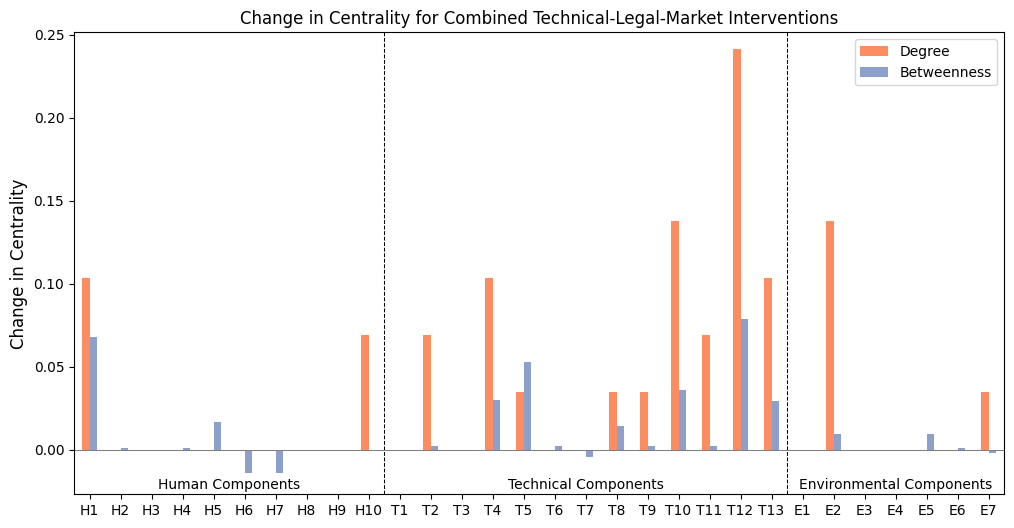

In [91]:
#nodelist=['H1','H2','H3','H4','H5','T5','T11','E5','E6']
plotter=centralchangeldb
a=plotter.plot.bar(color=[cmap(1), cmap(2)],figsize=(12,6))
plt.xticks(rotation=0)

# Vertical separators
a.axvline(h_end + 0.5, color="black", linewidth=0.75, linestyle="--")
a.axvline(t_end + 0.5, color="black", linewidth=0.75, linestyle="--")
a.axhline(0, color="grey", linewidth=0.75)
# Slightly increase space below zero
ymin = plotter.min().min()
ymax = plotter.max().max()
a.set_ylim(ymin - 0.05*(ymax-ymin), ymax+0.01)

# Axis labels
a.set_xlabel("")
a.set_ylabel("Change in Centrality", fontsize=12)


# Bracket drawing in axes coordinates (label only, no ticks)
def add_bracket(ax, x0, x1, label, y=-0.1):
    """
    x0, x1 are positions in data coordinates.
    y is relative to axis coords (negative = below x-axis).
    Only the label is drawn, no side ticks.
    """
    transform = ax.get_xaxis_transform()  # x in data, y in axis fraction

    # Label in the middle
    ax.text((x0 + x1) / 2, y, label, ha="center", va="top",
            transform=transform, fontsize=10, color="black")

# Add brackets ABOVE the ticks
add_bracket(a, -0.5, h_end+0.5, "Human Components", y=0.035)
add_bracket(a, h_end+0.5, t_end+0.5, "Technical Components", y=0.035)
add_bracket(a, t_end+0.5, len(plotter.index)-0.5, "Environmental Components", y=0.035)

# Legend
handles, _ = a.get_legend_handles_labels()
a.legend(handles, ["Degree", "Betweenness"])

plt.title('Change in Centrality for Combined Technical-Legal-Market Interventions')

In [70]:
source="T5"
target="E5"

#number of simple paths
print('# of simple paths', len(list(nx.all_simple_paths(OM,source=source,target=target))))

#shortest path description
paths=nx.all_shortest_paths(OM,source=source,target=target)

for pathz in map(nx.utils.pairwise, paths):
        #print(tuple(pathz))
        a=tuple(pathz)
        for k in a:
            print(k)
            print(B[k[0]][k[1]])

#upstream = [n for n in nx.traversal.bfs_tree(ingraph, targetnode, reverse=True) if n != targetnode]

# of simple paths 69
('T5', 'E5')
{'K5': {'description': 'Mercury discharged to nearby ecosystems'}}


In [71]:
print(149/200)
print(183/235)

0.745
0.7787234042553192


Text(0.5, 1.0, 'Change in Centrality for Combined Technical-Legal-Market Interventions')

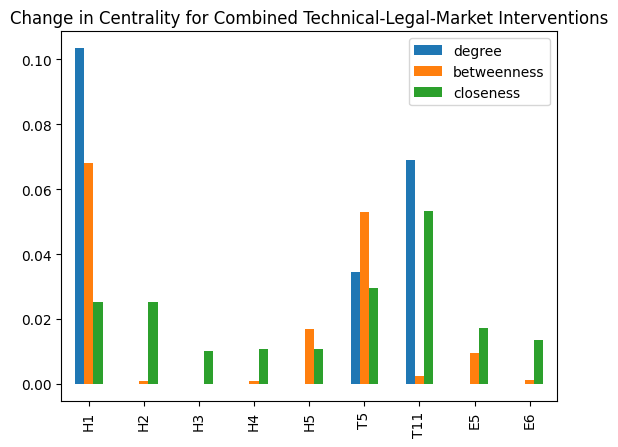

In [99]:
#make graphs for legal
deg=hte["Lgl_degree"]-hte["Base_degree"]
clo=hte["Lgl_closeness"]-hte["Base_closeness"]
bet=hte["Lgl_between"]-hte["Base_between"]
nodelist=['H1','H2','H3','H4','H5','T5','T11','E5','E6']
#make a dataframe
co=pd.DataFrame(clo[nodelist],bet[nodelist])
c2=pd.DataFrame(clist, index=columns, columns=list(central))
#fig, (ax1, ax2) = plt.subplots(1, 2)
co=(deg,bet,clo)
centralchange=pd.DataFrame(co, index=('degree','betweenness','closeness'))
centralchange=centralchange.T
centralchange
nodelist=['H1','H2','H3','H4','H5','T5','T11','E5','E6']
plotter=centralchange.loc[nodelist]
a=plotter.plot.bar()
plt.title('Change in Centrality for Combined Technical-Legal-Market Interventions')


Text(0.5, 1.0, 'Change in Centrality for Technical Interventions')

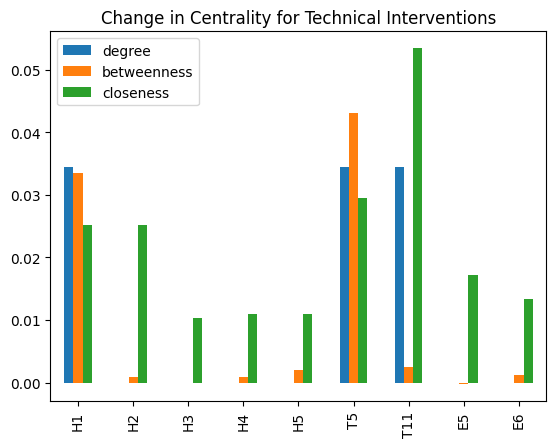

In [93]:
#make graphs for tech
deg=hte["Tech_degree"]-hte["Base_degree"]
clo=hte["Tech_closeness"]-hte["Base_closeness"]
bet=hte["Tech_between"]-hte["Base_between"]
nodelist=['H1','H2','H3','H4','H5','T5','T11','E5','E6']
#make a dataframe
co=pd.DataFrame(clo[nodelist],bet[nodelist])
c2=pd.DataFrame(clist, index=columns, columns=list(central))
#fig, (ax1, ax2) = plt.subplots(1, 2)
co=(deg,bet,clo)
centralchange=pd.DataFrame(co, index=('degree','betweenness','closeness'))
centralchange=centralchange.T
centralchange
nodelist=['H1','H2','H3','H4','H5','T5','T11','E5','E6']
plotter=centralchange.loc[nodelist]
a=plotter.plot.bar()
plt.title('Change in Centrality for Technical Interventions')


Text(0.5, 1.0, 'Change in Centrality for Market-Based Interventions')

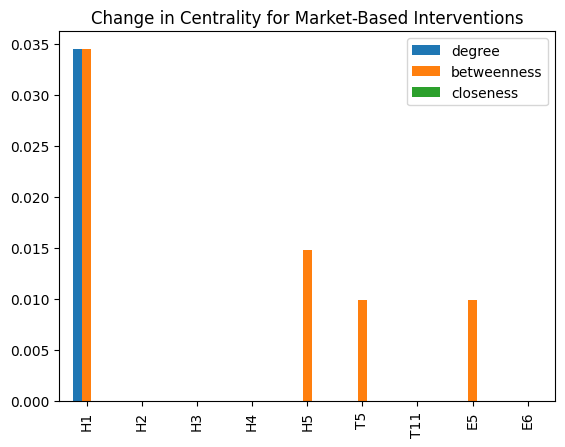

In [95]:
#make graphs for tech
deg=hte["Mkt_degree"]-hte["Tech_degree"]
clo=hte["Mkt_closeness"]-hte["Tech_closeness"]
bet=hte["Mkt_between"]-hte["Tech_between"]
nodelist=['H1','H2','H3','H4','H5','T5','T11','E5','E6']
#make a dataframe
co=pd.DataFrame(clo[nodelist],bet[nodelist])
c2=pd.DataFrame(clist, index=columns, columns=list(central))
#fig, (ax1, ax2) = plt.subplots(1, 2)
co=(deg,bet,clo)
centralchange=pd.DataFrame(co, index=('degree','betweenness','closeness'))
centralchange=centralchange.T
centralchange
nodelist=['H1','H2','H3','H4','H5','T5','T11','E5','E6']
plotter=centralchange.loc[nodelist]
a=plotter.plot.bar()
plt.title('Change in Centrality for Market-Based Interventions')


Text(0.5, 1.0, 'Change in Centrality for Legal Interventions')

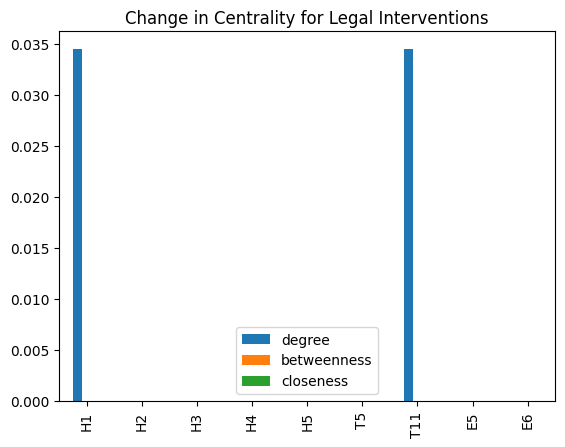

In [98]:
#make graphs for lgl
deg=hte["Lgl_degree"]-hte["Mkt_degree"]
clo=hte["Lgl_closeness"]-hte["Mkt_closeness"]
bet=hte["Lgl_between"]-hte["Mkt_between"]
nodelist=['H1','H2','H3','H4','H5','T5','T11','E5','E6']
#make a dataframe
co=pd.DataFrame(clo[nodelist],bet[nodelist])
c2=pd.DataFrame(clist, index=columns, columns=list(central))
#fig, (ax1, ax2) = plt.subplots(1, 2)
co=(deg,bet,clo)
centralchange=pd.DataFrame(co, index=('degree','betweenness','closeness'))
centralchange=centralchange.T
centralchange
nodelist=['H1','H2','H3','H4','H5','T5','T11','E5','E6']
plotter=centralchange.loc[nodelist]
a=plotter.plot.bar()
plt.title('Change in Centrality for Legal Interventions')


In [76]:
c4

,Base_degree,Base_between,Tech_degree,Tech_between,Mkt_degree,Mkt_between,Lgl_degree,Lgl_between,OpHg_degree,OpHg_between
H1,0.310345,0.137113,0.344828,0.170662,0.379310,0.205145,0.413793,0.205145,0.321429,0.128641
H2,0.275862,0.074200,0.275862,0.075130,0.275862,0.075130,0.275862,0.075130,0.285714,0.076014
H3,0.206897,0.032650,0.206897,0.032562,0.206897,0.032562,0.206897,0.032562,0.214286,0.033746
H4,0.172414,0.022475,0.172414,0.023399,0.172414,0.023399,0.172414,0.023399,0.178571,0.022817
H5,0.172414,0.142998,0.172414,0.145042,0.172414,0.159820,0.172414,0.159820,0.178571,0.135777
H6,0.206897,0.089028,0.206897,0.072433,0.206897,0.074896,0.206897,0.074896,0.214286,0.092404
H7,0.172414,0.056715,0.172414,0.042920,0.172414,0.042920,0.172414,0.042920,0.178571,0.058006
H8,0.068966,0.000000,0.068966,0.000000,0.068966,0.000000,0.068966,0.000000,0.071429,0.000000
H9,0.034483,0.000000,0.034483,0.000000,0.034483,0.000000,0.034483,0.000000,0.035714,0.000000
H10,0.000000,0.000000,0.000000,0.000000,0.068966,0.000000,0.068966,0.000000,0.000000,0.000000
